# COVID CLASSIFICATION WITH CHEST X RAY: Adapted ResNet

### Load required modules

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, NormalizeIntensity, RepeatChannel
from monai.metrics import compute_roc_auc

import pandas as pd
import matplotlib.pyplot as plt

import datetime
import random

import sklearn
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', None)

np.random.seed(0)
print_config()


MONAI version: 0.3.0
Python version: 3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56)  [GCC 7.3.0]
OS version: Linux (5.4.0-40-generic)
Numpy version: 1.19.1
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.16.2
Pillow version: 7.2.0
Tensorboard version: 2.2.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.48.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Set variables, load data and prepare it for work

In [2]:
working_directory = '/mnt/datasets/fastcovnet/'
columnToPredict = 'Case_type'
resolution = '224'
path_saved_model = os.path.expanduser("~")+'/best_metric_'+columnToPredict+'_'+resolution+'.pth'


In [3]:
# Read data
data = pd.read_csv(os.path.join(working_directory,'cohort_covid_20201115_nodups.csv'),"|")

# Double check target variable
data = data[data[columnToPredict].isna()==False]

# Convert columnToPredict to string
data[columnToPredict] = data[columnToPredict].astype(str)

In [4]:
# Value counts of classes of target var
class_names = sorted(data[columnToPredict].unique())
num_class = len(class_names)
data[columnToPredict].value_counts()

Control    22312
Case        6331
Name: Case_type, dtype: int64

In [5]:
# Create list with directory of images and their labels
data[columnToPredict] = pd.Categorical(data[columnToPredict])
data["to_predict"] = data[columnToPredict].cat.codes
dict(enumerate(data[columnToPredict].cat.categories))

image_file_list = data.path_jpg.tolist()
image_label_list = data.to_predict.tolist()

num_total = len(image_label_list) 

In [6]:
# Balance classes - force class balance, same number of cases and controls
num_cases = data[data[columnToPredict]=='Case'].shape[0]
data_casos = data[data[columnToPredict]=='Case']
data_controls = data[data[columnToPredict]=='Control'].sample(num_cases)
data = pd.concat([data_casos, data_controls])
num_total = num_cases*2
data[columnToPredict].value_counts()


Control    6331
Case       6331
Name: Case_type, dtype: int64

In [7]:
# Select from image_file_list and label_file_list the images that are actually in data after balancing
mapping = map(image_file_list.__getitem__, data.index.to_numpy())
image_file_list_2 = list(mapping)
mapping = map(image_label_list.__getitem__, data.index.to_numpy())
image_label_list_2 = list(mapping)

### Visualise some randomly picked examples from the dataset

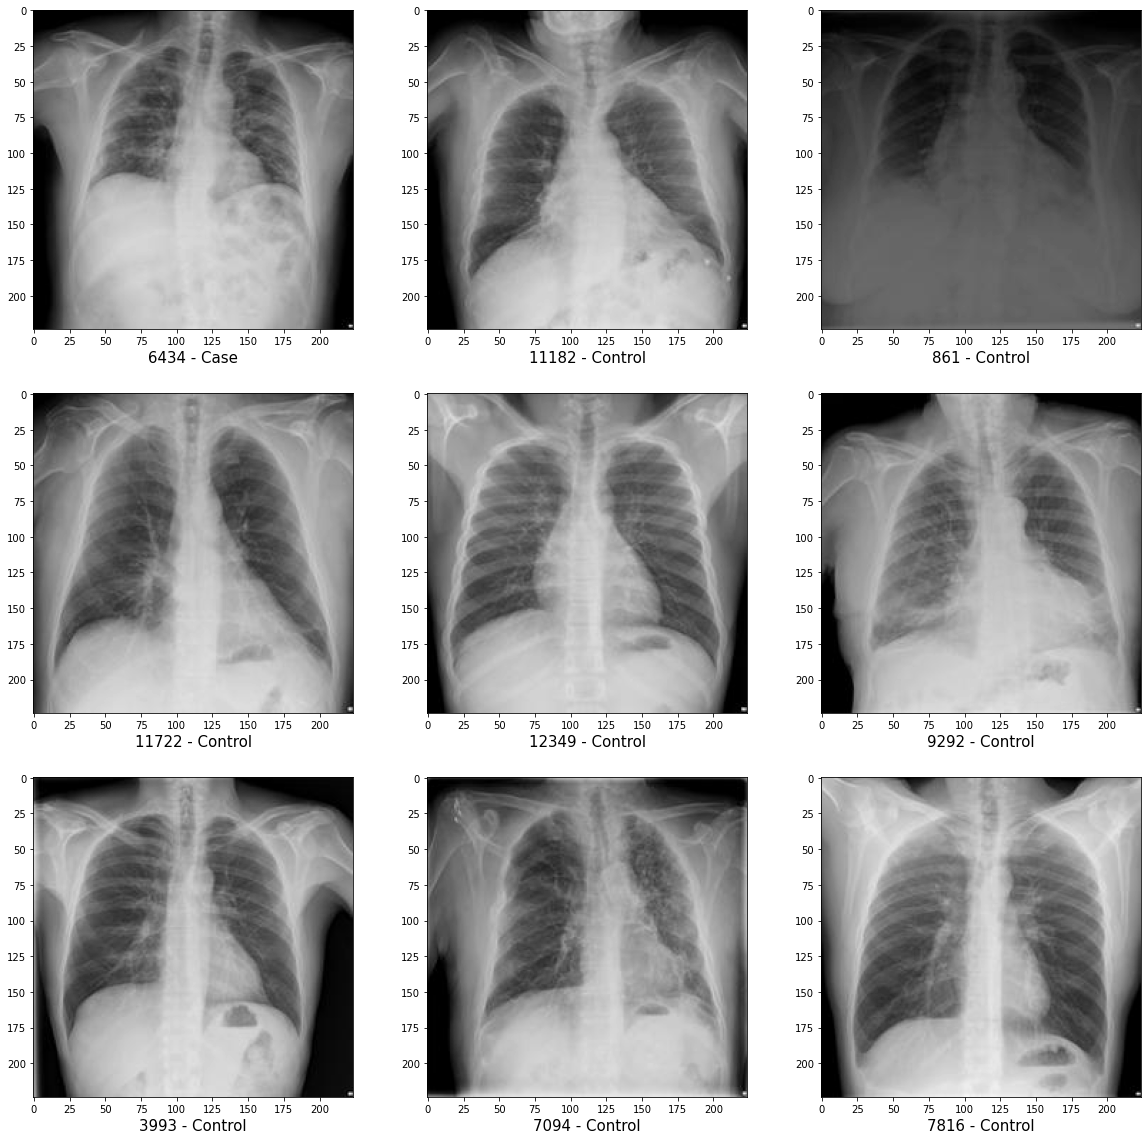

In [8]:
fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    ax[i//3][i%3].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//3][i%3].set_xlabel(str(k)+' - '+class_names[image_label_list[k]], fontsize=15)


### Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [9]:
# Settings
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

# Keep record of which split which image goes to (test, train, val). Later append to "data" csv
split = []

# Loop and select
for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list_2[i])
        valY.append(image_label_list_2[i])
        split.append('val')
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list_2[i])
        testY.append(image_label_list_2[i])
        split.append('test')
    else:
        trainX.append(image_file_list_2[i])
        trainY.append(image_label_list_2[i])
        split.append('train')

# Summary
print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 10092 Validation count = 1314 Test count = 1256


In [10]:
# Add the info of which split belongs to each datapoint to the table
path_split = pd.DataFrame({
    'path_jpg': image_file_list_2,
    'Split': split
})
data = pd.merge(data, path_split, on='path_jpg', how='left')

Check balance across splits

In [11]:
data[data['Split']=='train']['Case_type'].value_counts()

Case       5065
Control    5027
Name: Case_type, dtype: int64

In [12]:
data[data['Split']=='test']['Case_type'].value_counts()

Control    638
Case       618
Name: Case_type, dtype: int64

In [13]:
data[data['Split']=='val']['Case_type'].value_counts()

Control    666
Case       648
Name: Case_type, dtype: int64

### Define transforms, Dataset and Dataloader to pre-process data

In [14]:
imagenet_mean = np.array((np.full((224,224), 0.485), np.full((224,224), 0.456), np.full((224,224), 0.406)))
imagenet_std = np.array((np.full((224,224), 0.229), np.full((224,224), 0.224), np.full((224,224), 0.225)))

train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    RepeatChannel(3),
    ScaleIntensity(),
    #NormalizeIntensity(subtrahend=imagenet_mean, divisor=imagenet_std),
    RandRotate(range_x=90, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RepeatChannel(3),
    ToTensor()
])

In [15]:
# Define out Dataset class and create the dataloaders
class ChestCovNetDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = ChestCovNetDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=10)

val_ds = ChestCovNetDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=20, num_workers=10)

test_ds = ChestCovNetDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=20, num_workers=10)

# SPECIFIC PART: RESNET

### Define network, optimizer and loss

In [16]:
device = torch.device("cuda:0") # device
model = models.resnet152(pretrained=False) # model

### Modify model so that the output is 1 neuron with sigmoid
#model.conv1  = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#model.fc = nn.Linear(in_features = 2048, out_features = num_class, bias = True)
model.fc = nn.Sequential(
    nn.Linear(in_features = 2048, out_features = 1, bias = True),
    nn.Sigmoid()
    )
model = model.to(device)

## Model name and path to save model
model_name = model.__class__.__name__
path_saved_model = os.path.expanduser("~")+'/best_metric_'+model_name+'_'+resolution+'.pth'

## Loss and optimizer
#loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

epoch_num = 40
val_interval = 1 # How often will we validate

In [17]:
#model

### Model training

In [18]:
# Set check for saving the best model during training
if 'best_metric' not in vars():
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    val_loss_values = list()
    metric_values = list()
    checkpoint = {} # for saving model and other training info

# Not used
early_stop = False
patience_tol = 1e-2

# Measure time
start = datetime.datetime.now()

# Train
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device) #float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step # average loss
    epoch_loss_values.append(epoch_loss) # save loss
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Evaluation
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].float().to(device)
                y_pred = torch.cat([y_pred, model(val_images).view(-1)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            auc_metric = roc_auc_score(y.cpu(), y_pred.cpu()) # compute auc
            metric_values.append(auc_metric) # save auc
            
            score = y_pred>0.5
            acc_value = torch.eq(score, y) # compute accuracy
            acc_metric = acc_value.sum().item() / len(acc_value) # average accuracy
            
            valid_loss = loss_function(y_pred, y) # compute loss
            print(valid_loss)
            val_loss_values.append(valid_loss)
            
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                checkpoint['model'] = model.state_dict()
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
            #if epoch>4:
            #    if val_loss_values[epoch]-val_loss_values[epoch-4] < patience_tol:
            #        best_metric = auc_metric
            #        best_metric_epoch = epoch + 1
            #        checkpoint['model'] = model.state_dict()
            #        print('saved new best metric model')
            #        print(f"train completed, early stop, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
            #        early_stop = True
            #        break
                    
                    
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

time = datetime.datetime.now() - start


----------
epoch 1/40
epoch 1 average loss: 0.6754
tensor(0.6651, device='cuda:0')
saved new best metric model
current epoch: 1 current AUC: 0.6366 current accuracy: 0.5769 best AUC: 0.6366 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 0.6548
tensor(0.6300, device='cuda:0')
saved new best metric model
current epoch: 2 current AUC: 0.7048 current accuracy: 0.6324 best AUC: 0.7048 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.6464
tensor(0.6331, device='cuda:0')
saved new best metric model
current epoch: 3 current AUC: 0.7248 current accuracy: 0.6248 best AUC: 0.7248 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.6350
tensor(0.6149, device='cuda:0')
saved new best metric model
current epoch: 4 current AUC: 0.7410 current accuracy: 0.6773 best AUC: 0.7410 at epoch: 4
----------
epoch 5/40
epoch 5 average loss: 0.6264
tensor(0.6083, device='cuda:0')
current epoch: 5 current AUC: 0.7410 current accuracy: 0.6667 best AUC: 0.7410 at epoch: 4
----------
epoch 6

KeyboardInterrupt: 

### Save the model

In [ ]:
# Save model and current status
checkpoint['optimizer'] = optimizer.state_dict()
checkpoint['epoch_loss_values'] = epoch_loss_values
checkpoint['metric_values'] = metric_values

torch.save(checkpoint, path_saved_model)

### Load the model

In [ ]:
# Load the best model and our current training state
checkpoint = torch.load(path_saved_model)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

epoch_loss_values = checkpoint['epoch_loss_values']
metric_values = checkpoint['metric_values']

## Plot the loss and metric

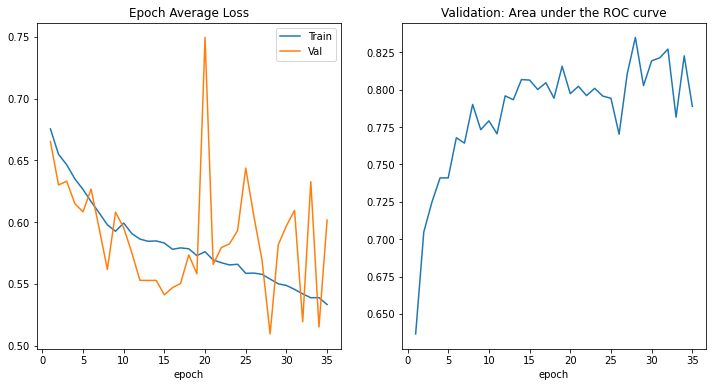

In [19]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.plot(x, y)
x = [i + 1 for i in range(len(val_loss_values))]
y = val_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.savefig("/home/bvelasco/Results/ResNet/Exp3_untrain_norm.jpg") # Save experiment
plt.show()

## Evaluate the model on test dataset

In [20]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            if pred[i]>=0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
            

In [21]:
# Append predicted values in test set to data table
predicted_result = pd.DataFrame(
    {'path_jpg': testX,
     'true': y_true,
     'predicted': y_pred
    })
data = pd.merge(data, predicted_result, on='path_jpg', how='left')


In [22]:
# Compute metrics
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Case     0.7445    0.7686    0.7564       618
     Control     0.7686    0.7445    0.7564       638

    accuracy                         0.7564      1256
   macro avg     0.7566    0.7566    0.7564      1256
weighted avg     0.7568    0.7564    0.7564      1256



In [23]:
# Save experiment metrics and info
with open('/home/bvelasco/Results/ResNet/result_log_Exp3_untrain_norm.txt', 'a') as f:
    f.write("#############################################################################\n")
    f.write(f'Model: {model_name} \n')
    f.write(f'Training epochs: {epoch} \n')
    f.write(f'Batch size: {40} \n')
    #f.write(f'Training time: {time} \n')
    f.write(f'Results: \n')
    f.write(f'{classification_report(y_true, y_pred, target_names=class_names, digits=4)} \n')
    

### Check distribution of errors per age group
Check the distribution of the percentage of wrongly classified datapoints per age group, to detect a potential bias of the network.

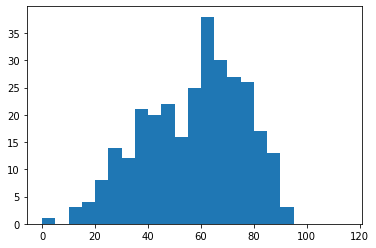

In [24]:
bins=[x for x in range(0,120,5)] # age groups
# Errors per age group
errors_perage = plt.hist(data[(data['predicted']!=data['true']) & (data['Split']=='test')]['EDAT_PROVA_DX'], bins)

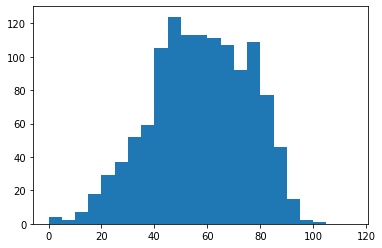

In [25]:
# Datapoints per age group
cases_perage = plt.hist(data[(data['Split']=='test')]['EDAT_PROVA_DX'], bins)

In [26]:
# Percentage of errors per age group
error_percent_perage = np.divide(errors_perage[0],cases_perage[0])*100

/home/bvelasco/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [27]:
error_percent_perage = np.nan_to_num(error_percent_perage)

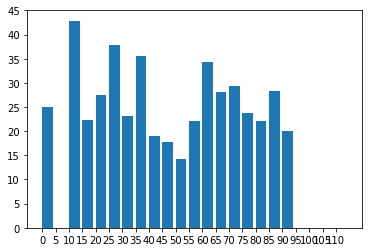

In [28]:
# Display histogram
plt.bar(np.arange(len(bins)-1), error_percent_perage, align='edge')
plt.xticks(np.arange(len(bins)-1), bins[:-1])
plt.savefig("/home/bvelasco/Results/ResNet/Exp2_Exp3_untrain_norm.jpg")
plt.show()

In [ ]:
###################################################################